In [30]:
import os
import pandas as pd
from pathlib import Path

# Define the project root explicitly
project_root = Path("/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours")
os.chdir(project_root)
print("New Working Directory:", os.getcwd())
print("Path.cwd():", Path.cwd())

# Set base path to 'data/cleaned' within the project
base_path = project_root / "data" / "cleaned"
print("Base Path:", base_path)

# Verify base path
if not base_path.exists():
    raise FileNotFoundError(f"Base path does not exist: {base_path}")
print("Contents of Base Path:", list(base_path.iterdir()))

# Function to load CSV files
def load_csv_tables(base_path, file_names):
    tables = {}
    for file_name in file_names:
        file_path = base_path / file_name
        if file_path.exists():
            table_name = file_path.stem  # Extracts the filename without extension
            tables[table_name] = pd.read_csv(file_path)
            print(f"Loaded: {file_name}")
        else:
            print(f"File not found: {file_path}")
    return tables

# File names
file_names = [
    'table_1_refined.csv',
    'table_2_refined.csv',
    'table_3_refined.csv',
    'table_4_refined.csv',
    'table_5_refined.csv',
    'table_6_refined.csv',
    'table_7_refined.csv',
    'table_8_refined.csv'
]

# Load tables
tables = load_csv_tables(base_path, file_names)

# Verify loaded tables
if not tables:
    print("WARNING: No tables were loaded. Please check file paths.")
else:
    print("Tables Loaded:", list(tables.keys()))


New Working Directory: /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours
Path.cwd(): /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours
Base Path: /Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned
Contents of Base Path: [PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_5_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_3_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_6_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_1_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Telework_Hours/data/cleaned/table_8_refined.csv'), PosixPath('/Users/abdurrahman/Documents/Data Bootcamp/Finals/Predicting_Te

Tables loaded:
table_1_refined
table_2_refined
table_3_refined
table_4_refined
table_5_refined
table_6_refined
table_7_refined
table_8_refined

--- Table_1_refined Head ---


,Characteristic,Total persons at work1,Total,Teleworked some hours2,Teleworked all hours,Persons who did not telework or work at home for pay,Total persons at work1.1,Total.1,Teleworked some hours2.1,Teleworked all hours.1,Persons who did not telework or work at home for pay.1
0,"Total, 16 years and over",157329,37340,19819,17521,119989,100,23.7,12.6,11.1,76.3
1,16 to 24 years,18851,1439,873,567,17412,100,7.6,4.6,3.0,92.4
2,16 to 19 years,5204,175,58,117,5030,100,3.4,1.1,2.2,96.6
3,20 to 24 years,13647,1265,815,450,12382,100,9.3,6.0,3.3,90.7
4,25 to 54 years,101798,26734,14430,12304,75064,100,26.3,14.2,12.1,73.7



--- Table_2_refined Head ---


,Characteristic,Total persons at work1,Total,Teleworked some hours2,Teleworked all hours,Persons who did not telework or work at home for pay,Total persons at work1.1,Total.1,Teleworked some hours2.1,Teleworked all hours.1,Persons who did not telework or work at home for pay.1
0,"Total, 16 years and over",157329,37340,19819,17521,119989,100,23.7,12.6,11.1,76.3
1,Full-time workers,130756,32816,18172,14644,97939,100,25.1,13.9,11.2,74.9
2,Part-time workers,26573,4524,1648,2876,22049,100,17.0,6.2,10.8,83.0
3,"Management, professional, and related occupations",68917,27102,15042,12060,41815,100,39.3,21.8,17.5,60.7
4,"Management, business, and financial operat...",30097,13977,7488,6489,16120,100,46.4,24.9,21.6,53.6



--- Table_3_refined Head ---


,Characteristic,Number of persons (in thousands),Average weekly hours teleworked or worked at home for pay,Average weekly hours worked,Hours teleworked or worked at home for pay as a percent of hours worked2,Number of persons (in thousands).1,Average weekly hours teleworked or worked at home for pay.1,Average weekly hours worked.1,Hours teleworked or worked at home for pay as a percent of hours worked2.1
0,"Total, 16 years and over",157329,6.3,38.6,16.4,37340,26.7,40.1,66.6
1,16 to 24 years,18851,1.5,31.4,4.8,1439,19.6,34.5,57.0
2,16 to 19 years,5204,0.5,23.4,2.0,175,14.1,21.0,67.0
3,20 to 24 years,13647,1.9,34.4,5.5,1265,20.4,36.3,56.2
4,25 to 54 years,101798,7.2,40.2,17.8,26734,27.2,41.0,66.5



--- Table_4_refined Head ---


,Characteristic,Number of persons (in thousands),Average weekly hours teleworked or worked at home for pay,Average weekly hours worked,Hours teleworked or worked at home for pay as a percent of hours worked2,Number of persons (in thousands).1,Average weekly hours teleworked or worked at home for pay.1,Average weekly hours worked.1,Hours teleworked or worked at home for pay as a percent of hours worked2.1
0,"Total, 16 years and over",157329,6.3,38.6,16.4,37340,26.7,40.1,66.6
1,Full-time workers,130756,7.1,42.2,16.8,32816,28.3,42.8,66
2,Part-time workers,26573,2.6,20.7,12.6,4524,15.2,20.2,75.4
3,"Management, professional, and related occupations",68917,10.4,40.0,26.1,27102,26.5,40.5,65.5
4,"Management, business, and financial operat...",30097,12.9,41.8,30.9,13977,27.8,41.4,67.2



--- Table_5_refined Head ---


,Characteristic,Total,Teleworked some hours1,Teleworked all hours,Total.1,Teleworked some hours1.1,Teleworked all hours.1,Total.2,Teleworked some hours1.2,Teleworked all hours.2
0,"Total, 16 years and over",37340,19819,17521,100,53.1,46.9,26.7,17.4,37.2
1,16 to 24 years,1439,873,567,100,60.6,39.4,19.6,14.5,27.6
2,16 to 19 years,175,58,117,100,33.4,66.6,14.1,-,14.2
3,20 to 24 years,1265,815,450,100,64.4,35.6,20.4,14.5,31.1
4,25 to 54 years,26734,14430,12304,100,54.0,46.0,27.2,17.6,38.6



--- Table_6_refined Head ---


,Characteristic,Total,Teleworked some hours1,Teleworked all hours,Total.1,Teleworked some hours1.1,Teleworked all hours.1,Total.2,Teleworked some hours1.2,Teleworked all hours.2
0,"Total, 16 years and over",37340,19819,17521,100,53.1,46.9,26.7,17.4,37.2
1,Full-time workers,32816,18172,14644,100,55.4,44.6,28.3,18.1,40.9
2,Part-time workers,4524,1648,2876,100,36.4,63.6,15.2,9.7,18.4
3,"Management, professional, and related occupations",27102,15042,12060,100,55.5,44.5,26.5,17.4,37.9
4,"Management, business, and financial operat...",13977,7488,6489,100,53.6,46.4,27.8,18.4,38.7



--- Table_7_refined Head ---


,Unnamed: 0,Unnamed: 1,Weekly hours teleworked or worked at home for pay,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Characteristic,"Total, persons who teleworked or worked at hom...",Up to 8 \nhours,9 to 16 \nhours,17 to 24 \nhours,25 to 32 \nhours,33 to 39 \nhours,Total,40 hours,41 hours \nor more,Average weekly hours teleworked,Total,Up to 8 \nhours,9 to 16 \nhours,17 to 24 \nhours,25 to 32 \nhours,33 to 39 \nhours,Total,40 hours,41 hours \nor more
1,"Total, 16 years and over",37340,6106,7215,5226,3890,1284,13620,9903,3716,26.7,100,16.4,19.3,14,10.4,3.4,36.5,26.5,10
2,16 to 24 years,1439,445,333,227,108,33,292,271,20,19.6,100,30.9,23.2,15.8,7.5,2.3,20.3,18.9,1.4
3,16 to 19 years,175,86,28,33,3,9,17,12,5,14.1,100,49.2,15.8,18.9,1.5,5.1,9.5,6.8,2.7
4,20 to 24 years,1265,359,306,194,106,25,275,259,16,20.4,100,28.4,24.2,15.4,8.4,1.9,21.8,20.5,1.2



--- Table_8_refined Head ---


,Unnamed: 0,Unnamed: 1,Weekly hours teleworked or worked at home for pay,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Characteristic,"Total, persons who teleworked or worked at hom...",Up to 8 \nhours,9 to 16 \nhours,17 to 24 \nhours,25 to 32 \nhours,33 to 39 \nhours,Total,40 hours,41 hours \nor more,Average weekly hours teleworked,Total,Up to 8 \nhours,9 to 16 \nhours,17 to 24 \nhours,25 to 32 \nhours,33 to 39 \nhours,Total,40 hours,41 hours \nor more
1,"Total, 16 years and over",37340,6106,7215,5226,3890,1284,13620,9903,3716,26.7,100,16.4,19.3,14,10.4,3.4,36.5,26.5,10
2,Full-time workers,32816,4756,5943,4210,3125,1218,13564,9873,3691,28.3,100,14.5,18.1,12.8,9.5,3.7,41.3,30.1,11.2
3,Part-time workers,4524,1350,1272,1016,764,66,56,31,25,15.2,100,29.8,28.1,22.5,16.9,1.5,1.2,0.7,0.6
4,"Management, professional, and related occupations",27102,4433,5461,3859,2709,937,9704,6991,2712,26.5,100,16.4,20.1,14.2,10,3.5,35.8,25.8,10



--- Table_1_refined Summary Statistics ---


,Characteristic,Total persons at work1,Total,Teleworked some hours2,Teleworked all hours,Persons who did not telework or work at home for pay,Total persons at work1.1,Total.1,Teleworked some hours2.1,Teleworked all hours.1,Persons who did not telework or work at home for pay.1
count,57,57.000000,57.000000,57.000000,57.000000,57.000000,57.0,57.000000,57.000000,57.000000,57.000000
unique,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,39604.157895,9637.368421,5125.140351,4512.228070,29966.842105,100.0,23.050877,12.110526,10.940351,76.949123
std,NaN,39546.711910,10156.355504,5451.993454,4720.281964,29768.365515,0.0,8.783672,4.847263,4.191780,8.783672
min,NaN,5079.000000,175.000000,58.000000,117.000000,3325.000000,100.0,3.400000,1.100000,2.000000,55.400000
25%,NaN,13434.000000,2257.000000,1201.000000,1246.000000,10475.000000,100.0,19.400000,9.700000,9.100000,73.200000
50%,NaN,22461.000000,4867.000000,2393.000000,2550.000000,17412.000000,100.0,24.000000,12.600000,11.400000,76.000000
75%,NaN,53384.000000,13813.000000,7340.000000,6091.000000,36518.000000,100.0,26.800000,14.400000,13.400000,80.600000



--- Table_2_refined Summary Statistics ---


,Characteristic,Total persons at work1,Total,Teleworked some hours2,Teleworked all hours,Persons who did not telework or work at home for pay,Total persons at work1.1,Total.1,Teleworked some hours2.1,Teleworked all hours.1,Persons who did not telework or work at home for pay.1
count,74,74.000000,74.000000,74.000000,74.000000,74.000000,74.0,74.000000,74.000000,74.000000,74.000000
unique,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,"Total, 16 years and over",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20281.378378,4945.175676,2638.081081,2307.121622,15336.189189,100.0,24.309459,13.183784,11.137838,75.690541
std,NaN,34542.043470,8705.684893,4678.106053,4048.963419,26259.550268,0.0,17.011794,8.855569,9.024984,17.011794
min,NaN,593.000000,48.000000,21.000000,23.000000,500.000000,100.0,1.700000,1.100000,0.600000,28.200000
25%,NaN,4871.750000,746.000000,408.250000,316.250000,3136.750000,100.0,11.525000,6.275000,4.550000,66.275000
50%,NaN,9409.000000,1440.000000,834.500000,576.500000,7357.000000,100.0,20.450000,11.900000,8.800000,79.550000
75%,NaN,15984.750000,4396.250000,2043.750000,2510.000000,12244.750000,100.0,33.725000,20.325000,14.375000,88.475000



--- Table_3_refined Summary Statistics ---


,Characteristic,Number of persons (in thousands),Average weekly hours teleworked or worked at home for pay,Average weekly hours worked,Hours teleworked or worked at home for pay as a percent of hours worked2,Number of persons (in thousands).1,Average weekly hours teleworked or worked at home for pay.1,Average weekly hours worked.1,Hours teleworked or worked at home for pay as a percent of hours worked2.1
count,57,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
unique,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,39604.157895,6.126316,37.940351,15.931579,9637.368421,26.038596,39.157895,66.494737
std,NaN,39546.711910,2.452734,3.391263,6.136866,10156.355504,2.753683,3.427825,4.027159
min,NaN,5079.000000,0.500000,23.400000,2.000000,175.000000,14.100000,21.000000,54.900000
25%,NaN,13434.000000,5.400000,37.300000,13.600000,2257.000000,26.200000,38.600000,65.000000
50%,NaN,22461.000000,6.300000,38.700000,16.400000,4867.000000,26.800000,40.100000,66.600000
75%,NaN,53384.000000,7.300000,40.000000,19.300000,13813.000000,27.300000,40.700000,69.100000



--- Table_4_refined Summary Statistics ---


,Characteristic,Number of persons (in thousands),Average weekly hours teleworked or worked at home for pay,Average weekly hours worked,Hours teleworked or worked at home for pay as a percent of hours worked2,Number of persons (in thousands).1,Average weekly hours teleworked or worked at home for pay.1,Average weekly hours worked.1,Hours teleworked or worked at home for pay as a percent of hours worked2.1
count,74,74.000000,74.000000,74.000000,74.000000,74.000000,74,74,74
unique,74,NaN,NaN,NaN,NaN,NaN,52,48,64
top,"Total, 16 years and over",NaN,NaN,NaN,NaN,NaN,25.3,40,65.2
freq,1,NaN,NaN,NaN,NaN,NaN,3,4,2
mean,NaN,20281.378378,6.339189,38.472973,16.304054,4945.175676,NaN,NaN,NaN
std,NaN,34542.043470,4.897492,3.520169,12.180609,8705.684893,NaN,NaN,NaN
min,NaN,593.000000,0.300000,20.700000,1.100000,48.000000,NaN,NaN,NaN
25%,NaN,4871.750000,2.925000,37.025000,7.825000,746.000000,NaN,NaN,NaN
50%,NaN,9409.000000,5.150000,39.000000,13.000000,1440.000000,NaN,NaN,NaN
75%,NaN,15984.750000,8.375000,40.675000,21.925000,4396.250000,NaN,NaN,NaN



--- Table_5_refined Summary Statistics ---


,Characteristic,Total,Teleworked some hours1,Teleworked all hours,Total.1,Teleworked some hours1.1,Teleworked all hours.1,Total.2,Teleworked some hours1.2,Teleworked all hours.2
count,57,57.000000,57.000000,57.000000,57.0,57.000000,57.000000,57.000000,57,57.000000
unique,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN
top,Women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.4,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
mean,NaN,9637.368421,5125.140351,4512.228070,100.0,52.415789,47.584211,26.038596,NaN,35.966667
std,NaN,10156.355504,5451.993454,4720.281964,0.0,5.633376,5.633376,2.753683,NaN,4.434295
min,NaN,175.000000,58.000000,117.000000,100.0,33.400000,35.600000,14.100000,NaN,14.200000
25%,NaN,2257.000000,1201.000000,1246.000000,100.0,49.300000,44.700000,26.200000,NaN,35.600000
50%,NaN,4867.000000,2393.000000,2550.000000,100.0,53.100000,46.900000,26.800000,NaN,37.300000
75%,NaN,13813.000000,7340.000000,6091.000000,100.0,55.300000,50.700000,27.300000,NaN,38.200000



--- Table_6_refined Summary Statistics ---


,Characteristic,Total,Teleworked some hours1,Teleworked all hours,Total.1,Teleworked some hours1.1,Teleworked all hours.1,Total.2,Teleworked some hours1.2,Teleworked all hours.2
count,74,74.000000,74.000000,74.000000,74.0,74,74,74,74,74
unique,74,NaN,NaN,NaN,NaN,68,68,52,47,52
top,"Total, 16 years and over",NaN,NaN,NaN,NaN,59.9,40.1,25.3,17.4,-
freq,1,NaN,NaN,NaN,NaN,2,2,3,4,7
mean,NaN,4945.175676,2638.081081,2307.121622,100.0,NaN,NaN,NaN,NaN,NaN
std,NaN,8705.684893,4678.106053,4048.963419,0.0,NaN,NaN,NaN,NaN,NaN
min,NaN,48.000000,21.000000,23.000000,100.0,NaN,NaN,NaN,NaN,NaN
25%,NaN,746.000000,408.250000,316.250000,100.0,NaN,NaN,NaN,NaN,NaN
50%,NaN,1440.000000,834.500000,576.500000,100.0,NaN,NaN,NaN,NaN,NaN
75%,NaN,4396.250000,2043.750000,2510.000000,100.0,NaN,NaN,NaN,NaN,NaN



--- Table_7_refined Summary Statistics ---


,Unnamed: 0,Unnamed: 1,Weekly hours teleworked or worked at home for pay,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
count,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58
unique,36,58,58,57,58,58,57,58,58,57,37,2,40,38,33,31,28,49,48,44
top,Men,"Total, persons who teleworked or worked at hom...",Up to 8 \nhours,306,17 to 24 \nhours,25 to 32 \nhours,110,Total,40 hours,247,26.4,100,15.9,19.2,13.8,10.4,3.5,37.1,24.7,7.2
freq,4,1,1,2,1,1,2,1,1,2,5,57,4,6,6,8,7,4,3,4



--- Table_8_refined Summary Statistics ---


,Unnamed: 0,Unnamed: 1,Weekly hours teleworked or worked at home for pay,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
count,75,75,75,75,75,75,74,75,74,74,75,75,75,75,75,75,75,75,75,75
unique,75,75,74,73,71,70,61,73,73,64,53,2,63,56,53,45,39,69,69,61
top,Characteristic,"Total, persons who teleworked or worked at hom...",58,277,129,55,8,56,117,97,25.6,100,19,19,14.1,10.4,-,33.1,-,10
freq,1,1,2,2,2,3,3,2,2,3,3,74,4,3,3,7,5,2,2,4



--- EDA for Table_1_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_1_refined. Skipping distribution plot.


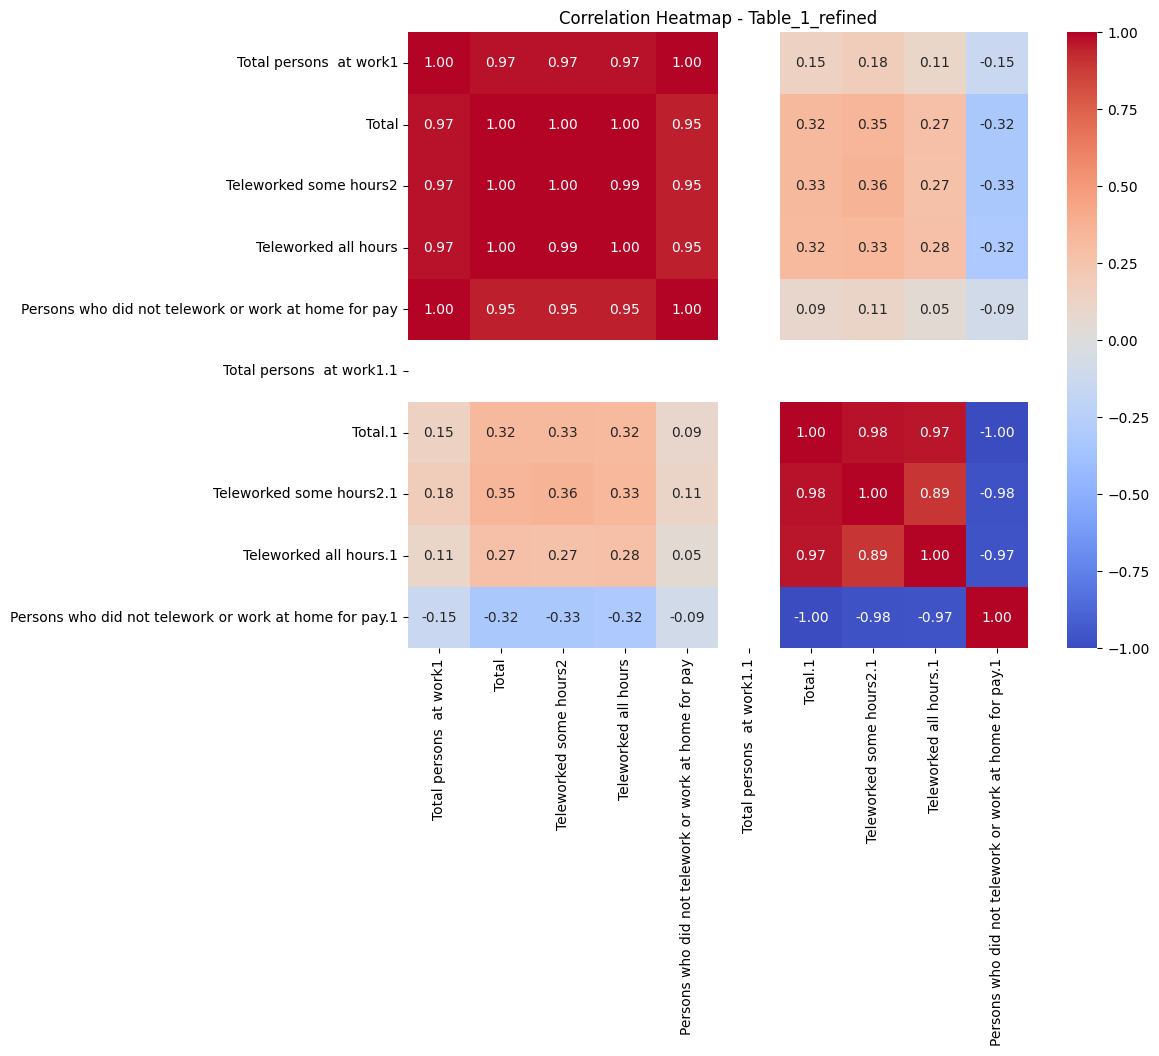


--- EDA for Table_2_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_2_refined. Skipping distribution plot.


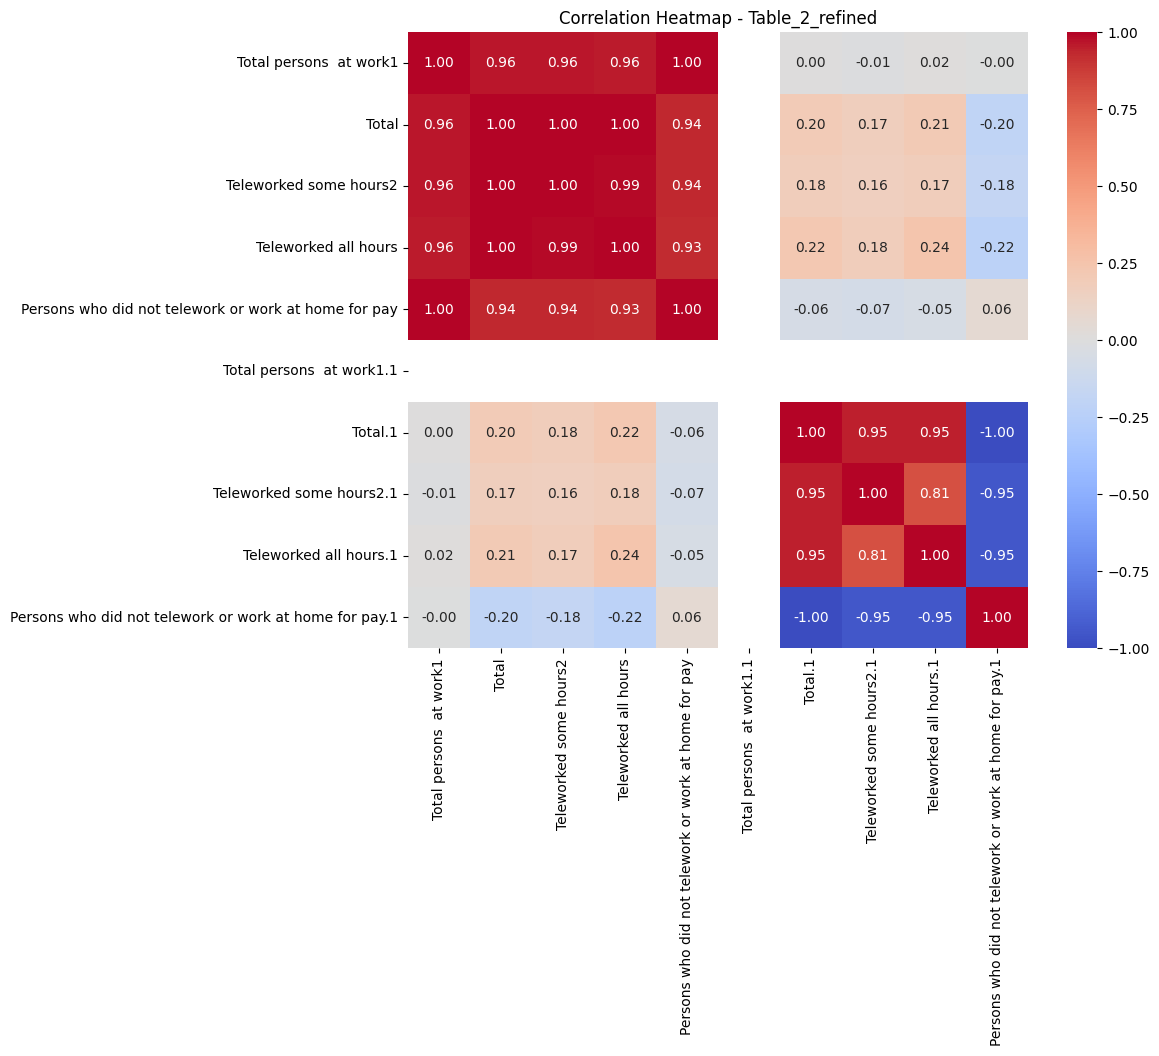


--- EDA for Table_3_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_3_refined. Skipping distribution plot.


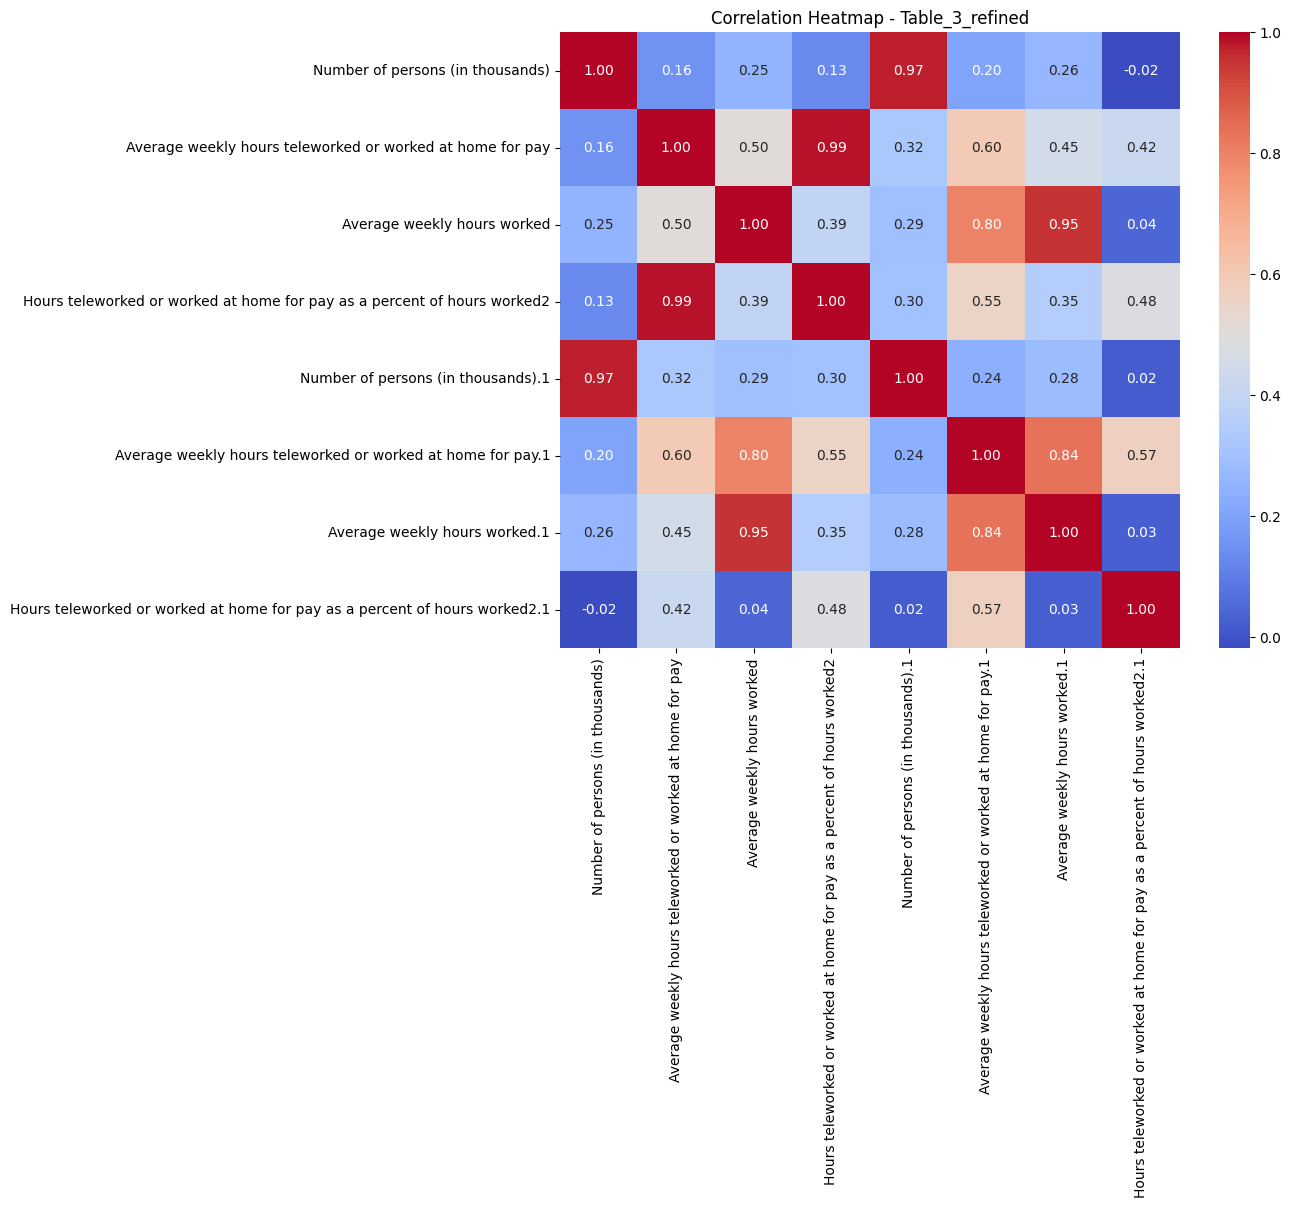


--- EDA for Table_4_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_4_refined. Skipping distribution plot.


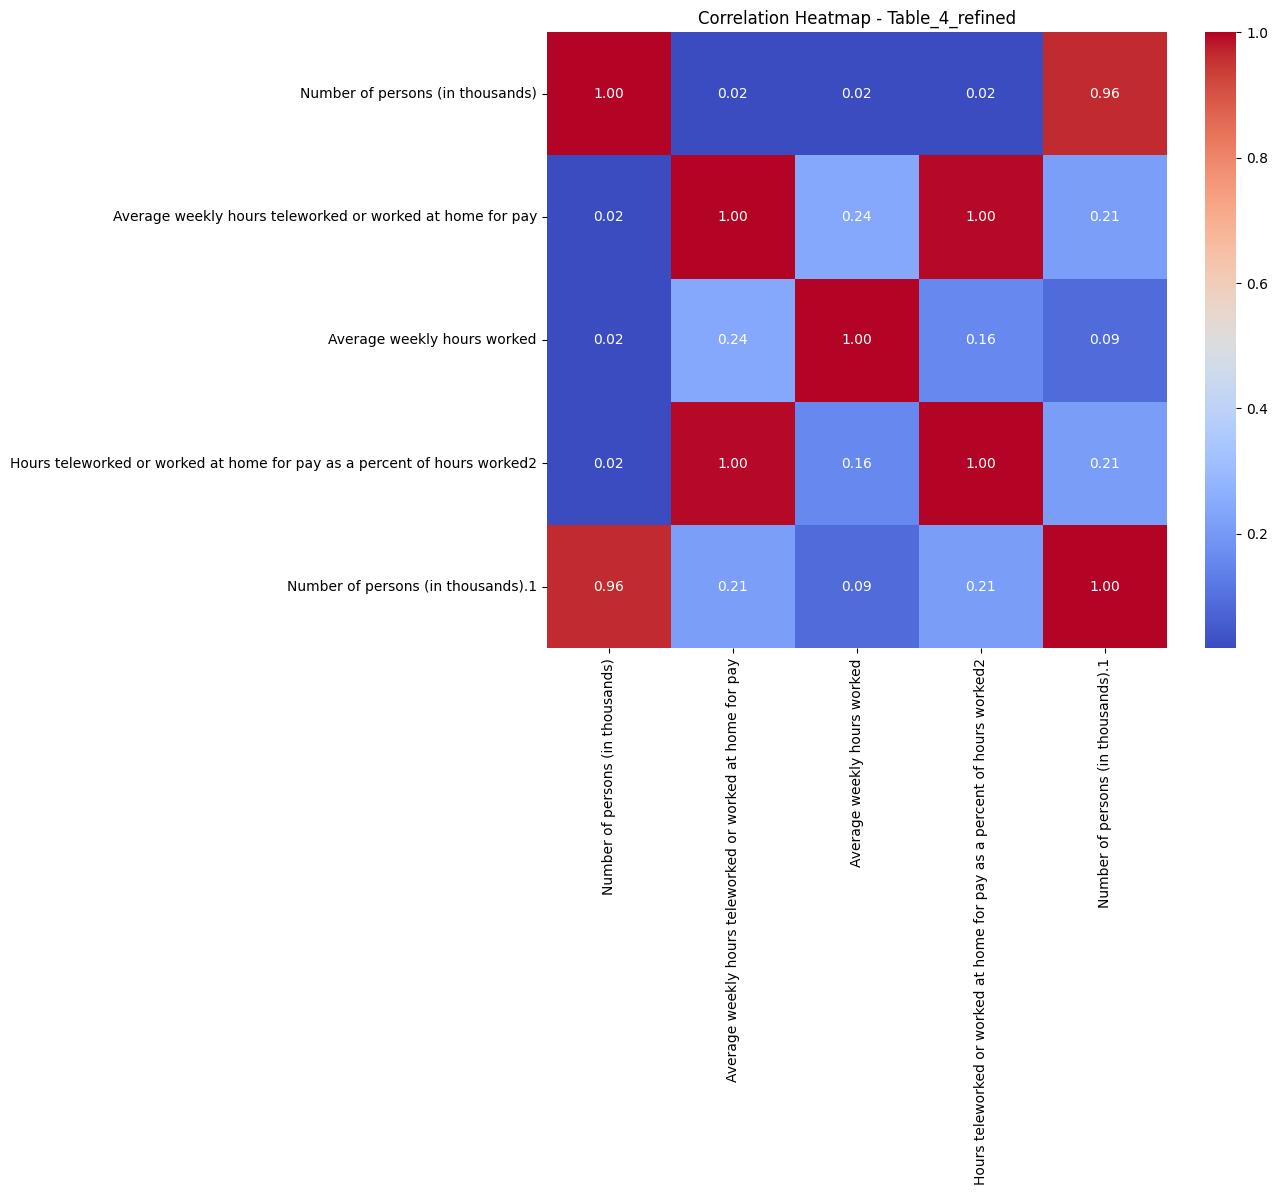


--- EDA for Table_5_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_5_refined. Skipping distribution plot.


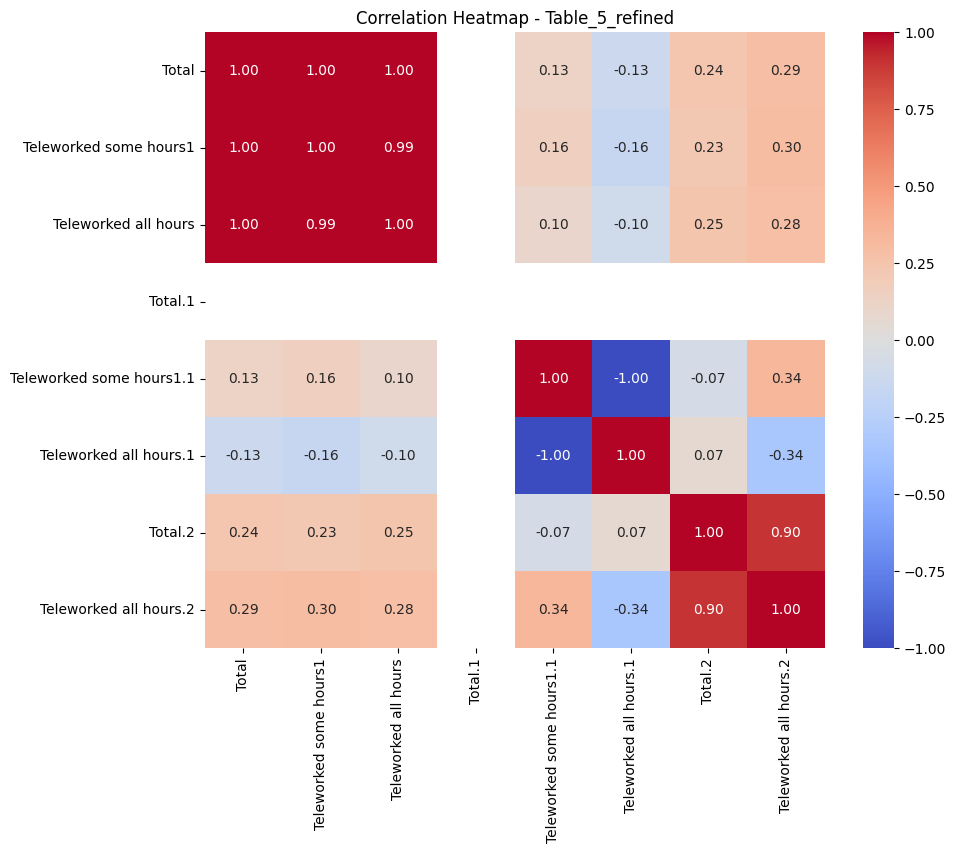


--- EDA for Table_6_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_6_refined. Skipping distribution plot.


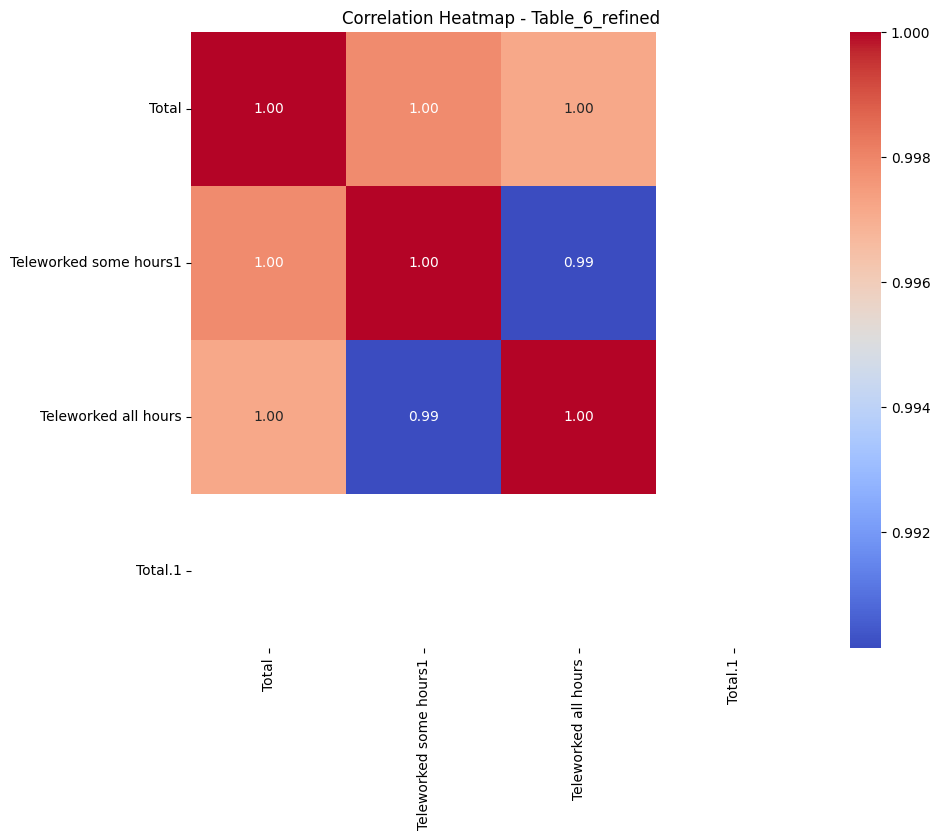


--- EDA for Table_7_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_7_refined. Skipping distribution plot.
No sufficient numeric columns in table_7_refined to compute correlations.

--- EDA for Table_8_refined ---
'Average_Weekly_Hours_Teleworked' not found in table_8_refined. Skipping distribution plot.
No sufficient numeric columns in table_8_refined to compute correlations.

Missing values in table_8_refined:
Unnamed: 6    1
Unnamed: 8    1
Unnamed: 9    1
dtype: int64


In [31]:
# Import additional libraries for EDA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Display loaded tables
print("Tables loaded:")
for k in tables.keys():
    print(k)

# Display head of each table
for table_name, df in tables.items():
    print(f"\n--- {table_name.capitalize()} Head ---")
    display(df.head())

# Basic summary statistics for each table
for table_name, df in tables.items():
    print(f"\n--- {table_name.capitalize()} Summary Statistics ---")
    display(df.describe(include='all'))

# Function to plot distribution of a specified column
def plot_distribution(df, column, title):
    plt.figure(figsize=(10,6))
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(title)
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.show()

# Function to plot correlation heatmap for numeric columns
def plot_correlation_heatmap(df, table_name):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        corr = df[numeric_cols].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Correlation Heatmap - {table_name.capitalize()}')
        plt.show()
    else:
        print(f"No sufficient numeric columns in {table_name} to compute correlations.")

# Perform EDA for each table
for table_name, df in tables.items():
    print(f"\n--- EDA for {table_name.capitalize()} ---")
    
    # Check for specific columns to plot (example: 'Average_Weekly_Hours_Teleworked')
    # Modify the column name as per your actual data
    telework_hours_col = 'Average_Weekly_Hours_Teleworked'  # Example column name
    if telework_hours_col in df.columns:
        plot_distribution(df, telework_hours_col, f"Distribution of {telework_hours_col.replace('_', ' ').title()} ({table_name.capitalize()})")
    else:
        print(f"'{telework_hours_col}' not found in {table_name}. Skipping distribution plot.")
    
    # Plot correlation heatmap
    plot_correlation_heatmap(df, table_name)

# Additional EDA Steps

# 1. Check for Missing Values
for k, df in tables.items():
    missing_count = df.isna().sum()
    if missing_count.sum() > 0:
        print(f"\nMissing values in {k}:")
        print(missing_count[missing_count > 0])

# 2. Examine Categorical Distributions (if applicable)
def plot_categorical_distribution(df, column, title):
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x=column, palette='viridis')
    plt.title(title)
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Example: Plot distribution for a categorical column 'Department'
categorical_cols_example = ['Department']  # Replace with actual categorical columns
for table_name, df in tables.items():
    for col in categorical_cols_example:
        if col in df.columns and df[col].dtype == 'object':
            plot_categorical_distribution(df, col, f"Distribution of {col.replace('_', ' ').title()} ({table_name.capitalize()})")
        elif col in df.columns:
            print(f"Column '{col}' in {table_name} is not categorical. Skipping.")
